In [12]:
# import packages needed 
import pandas as pd
import geopandas as gpd
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
import mapclassify as mc
import shapely as shp
from legendgram import legendgram
import palettable.matplotlib as palmpl
import esda
import libpysal as lps
from mgwr.sel_bw import Sel_BW
from mgwr.gwr import GWR, MGWR
import libpysal as ps

In [13]:
#Import data
zone = gpd.read_file('LSOA1.shp')
zone = zone.to_crs(epsg=27700)
zone.crs
zone.head(5)

,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,...,children,qualificat,Income,private,white,usual,unemploy,fire,density,geometry
0,E01000056,Barking and Dagenham 018C,E02000019,Barking and Dagenham 018,E09000002,Barking and Dagenham,E12000007,London,1584,1542,...,25.654450,16.5,27991.18909,15.7,67.550505,97.948718,11.714286,1.0,65.024631,"POLYGON ((548159.688 183849.000, 548159.688 18..."
1,E01000057,Barking and Dagenham 012A,E02000013,Barking and Dagenham 012,E09000002,Barking and Dagenham,E12000007,London,1496,1496,...,20.484171,21.2,28150.94556,13.4,64.906417,97.992701,9.388972,7.0,101.286391,"POLYGON ((547657.057 184359.696, 547656.921 18..."
2,E01000054,Barking and Dagenham 018A,E02000019,Barking and Dagenham 018,E09000002,Barking and Dagenham,E12000007,London,1718,1718,...,22.727273,16.6,28868.13884,13.2,71.245634,97.404580,10.253165,6.0,100.350467,"POLYGON ((548118.932 184237.573, 548119.763 18..."
3,E01000055,Barking and Dagenham 018B,E02000019,Barking and Dagenham 018,E09000002,Barking and Dagenham,E12000007,London,1553,1553,...,24.107143,18.4,29174.14100,13.0,69.671603,96.718480,11.038961,3.0,106.369863,"POLYGON ((547712.088 184031.898, 547718.365 18..."
4,E01000052,Barking and Dagenham 019D,E02000020,Barking and Dagenham 019,E09000002,Barking and Dagenham,E12000007,London,2014,2014,...,18.335501,24.6,27834.52323,21.6,46.474677,96.608040,8.650875,7.0,100.851277,"POLYGON ((544930.306 183835.826, 544933.000 18..."


In [14]:
labels = [ 'Intercept','Proportion of children', 'Family with child',  'Occupancy rate', 'Highly educated', 'Unemployment rate']

In [15]:
zone['centro']=zone.centroid
zone['X']=zone.centro.x
zone['Y']=zone.centro.y
coords = list(zip(zone['X'],zone['Y']))

In [16]:
y = np.array(zone['fire']).reshape((-1,1))
pop15 =np.array(zone['0_15']).reshape((-1,1))

children =np.array(zone['children']).reshape((-1,1))


usual =np.array(zone['usual']).reshape((-1,1))
education =np.array(zone['qualificat']).reshape((-1,1))


unemploy = np.array(zone['unemploy']).reshape((-1,1))
X = np.hstack([pop15, children,  usual,  education,  unemploy])

In [17]:
sel = Sel_BW(coords, y, X)
bw = sel.search()
print('bw:', bw)
gwr = GWR(coords, y, X, bw)
gwr_results = gwr.fit()
print('aicc:', gwr_results.aicc)
print('ENP:', gwr_results.ENP)
print('sigma2:', gwr_results.sigma2)

bw: 686.0
aicc: 24883.412087189405
ENP: 104.43302575079898
sigma2: 9.834360464194852


In [7]:
gwr_results.params.shape

(4835, 6)

In [18]:
zone.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   LSOA11CD    4835 non-null   object  
 1   LSOA11NM    4835 non-null   object  
 2   MSOA11CD    4835 non-null   object  
 3   MSOA11NM    4835 non-null   object  
 4   LAD11CD     4835 non-null   object  
 5   LAD11NM     4835 non-null   object  
 6   RGN11CD     4835 non-null   object  
 7   RGN11NM     4835 non-null   object  
 8   USUALRES    4835 non-null   int64   
 9   HHOLDRES    4835 non-null   int64   
 10  COMESTRES   4835 non-null   int64   
 11  POPDEN      4835 non-null   float64 
 12  HHOLDS      4835 non-null   int64   
 13  AVHHOLDSZ   4835 non-null   float64 
 14  Codes       4835 non-null   object  
 15  0_15        4835 non-null   float64 
 16  65_         4835 non-null   float64 
 17  children    4835 non-null   float64 
 18  qualificat  4835 non-null   float64 
 19

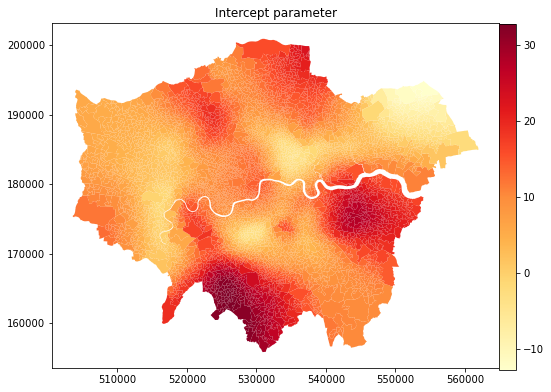

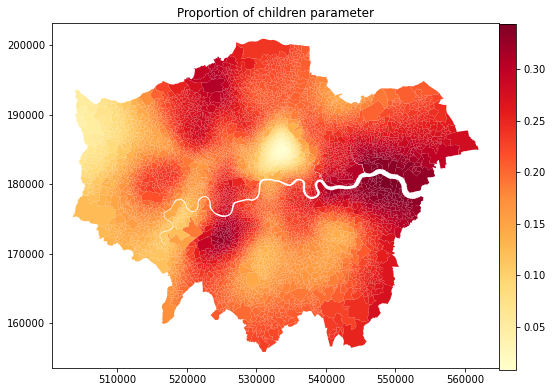

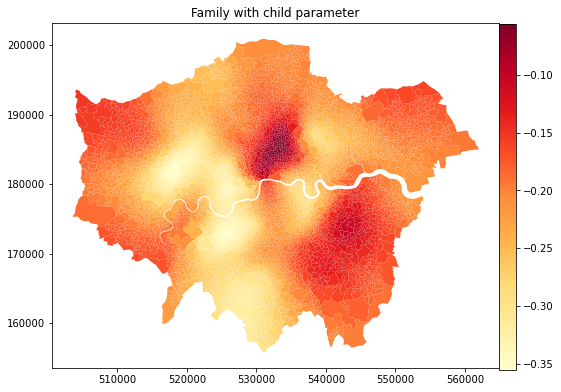

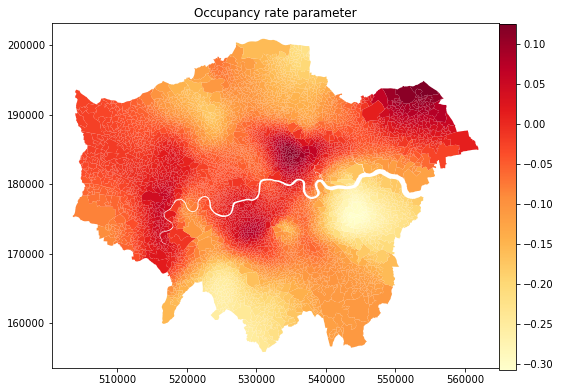

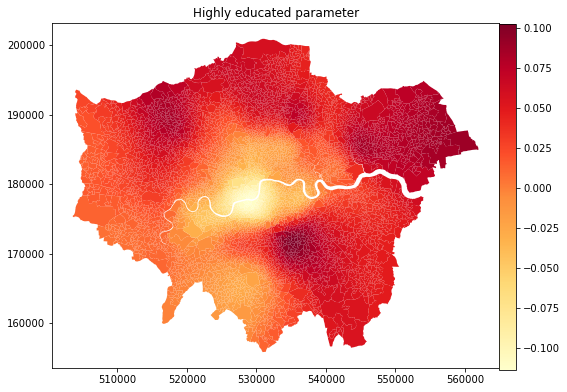

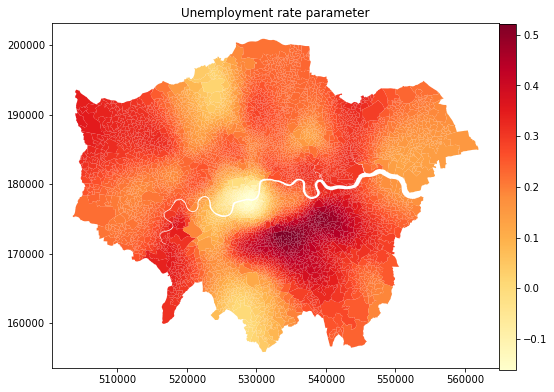

In [19]:
#Map Parameter estimates 


for param in range(gwr_results.params.shape[1]):
    zone[str(param)] = gwr_results.params[:,param]
    vmin, vmax = np.min(zone[str(param)]), np.max(zone[str(param)]) 
    ax = zone.plot(str(param), vmin=vmin, vmax=vmax, figsize=(8,8), cmap='YlOrRd')
    ax.set_title(labels[param] + ' parameter')
    fig = ax.get_figure()
    cax = fig.add_axes([0.9, 0.2, 0.03, 0.6])
    sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap='YlOrRd')
    sm._A = []
    fig.colorbar(sm, cax=cax)
    
    


In [20]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                4835
Number of covariates:                                                     6

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                          50352.906
Log-likelihood:                                                  -12525.194
AIC:                                                              25062.388
AICc:                                                             25064.411
BIC:                                                               9385.426
R2:                                                                   0.282
Adj. R2:                                                              0.281

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

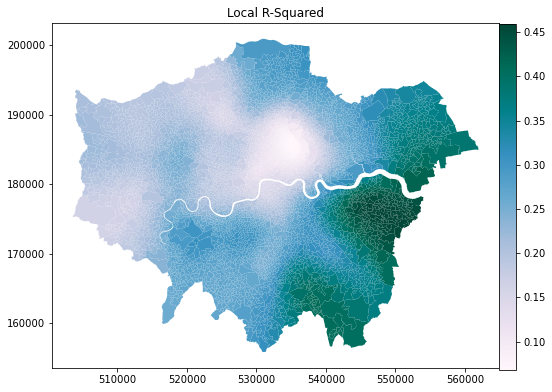

In [21]:
#Map local R-square values which is a weighted R-square at each observation location

zone['localR2'] = gwr_results.localR2
vmin, vmax = np.min(zone['localR2']), np.max(zone['localR2']) 
ax = zone.plot('localR2', vmin=vmin, vmax=vmax, figsize=(8,8), cmap='PuBuGn')
ax.set_title('Local R-Squared')
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.2, 0.03, 0.6])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap='PuBuGn')
sm._A = []
fig.colorbar(sm, cax=cax)
